# Chapter 6 - Linear Model Selection and Regularization

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)
- [Lab 3: Principal Components Regression](#6.7.1-Principal-Components-Regression)
- [Lab 3: Partial Least Squares](#6.7.2-Partial-Least-Squares)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-white')


# Lab 2

In [2]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [3]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                          
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                    
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N        E      805   
-Alfredo Griffin       19    501   336     194      A        W      282   

                   Assists  Errors  Salary NewLeague  
Player                                                
-Alan Ashby             43      10   475.0         N  
-Alvin Davis            82      14   480.0         A  
-Andre Dawson           11       3   500.0         N  
-Andres Galarraga       40       4    91.5         N  
-Alfredo Griffin       421      25   750.0         A

In [4]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [5]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [6]:
X.head(5)

AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat  \
Player                                                                     
-Alan Ashby        315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   
-Alvin Davis       479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   
-Andre Dawson      496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0   
-Andres Galarraga  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   
-Alfredo Griffin   594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0   

                    CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  \
Player                                                                      
-Alan Ashby         835.0    69.0  321.0  414.0   375.0    632.0     43.0   
-Alvin Davis        457.0    63.0  224.0  266.0   263.0    880.0     82.0   
-Andre Dawson      1575.0   225.0  828.0  838.0   354.0    200.0     11.0   
-Andres Galarraga   101.0    12.0   48.0   46.0    33.0    805.0     40.0   
-Alfredo Griffin   1133.0    19.0  501.0  336.0   194.0    282.0    421.0   

                   Errors  League_N  Division_W  NewLeague_N  
Player                                                        
-Alan Ashby          10.0         1           1            1  
-Alvin Davis         14.0         0           1            0  
-Andre Dawson         3.0         1           0            1  
-Andres Galarraga     4.0         1           0            1  
-Alfredo Griffin     25.0         0           1            0

#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [7]:
X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

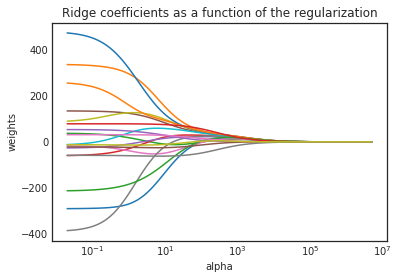

In [8]:
alphas = 5**np.linspace(10,-2,100)*0.5 

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [10]:
ridge2 = Ridge(alpha=4)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

97383.68965102117

In [11]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat         -161.784058
Hits           118.911404
HmRun           52.645719
Runs           -43.295947
RBI             37.339573
Walks          138.214992
Years         -106.916784
CAtBat         -21.080864
CHits          115.933862
CHmRun         -17.949420
CRuns          239.723217
CRBI           -17.945273
CWalks         -59.754770
PutOuts         21.752383
Assists        -68.676906
Errors          89.610291
League_N        31.048268
Division_W     -13.553466
NewLeague_N      4.350305
dtype: float64

#### Alpha = $10^{10}$  (Alpha graph & find optimal alpha)
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [12]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

In [13]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          2.291553e-06
Hits           2.428111e-06
HmRun          2.051677e-06
Runs           2.372252e-06
RBI            2.538921e-06
Walks          2.974270e-06
Years          1.572334e-06
CAtBat         2.507043e-06
CHits          2.666936e-06
CHmRun         2.280416e-06
CRuns          2.839982e-06
CRBI           2.526355e-06
CWalks         2.544939e-06
PutOuts        4.880225e-07
Assists       -1.149268e-06
Errors         2.067779e-06
League_N       5.324293e-07
Division_W     5.051366e-07
NewLeague_N    5.291999e-07
dtype: float64

#### Training mse with different alpha value

Text(0.5, 1.0, 'Training mse with different alpha')

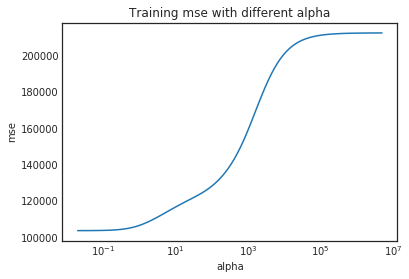

In [14]:
alphas = 5**np.linspace(10,-2,100)*0.5 

mse = []

for a in alphas:
    ridge2 = Ridge(alpha=a)
    ridge2.fit(scaler.transform(X_train), y_train)
    pred = ridge2.predict(scaler.transform(X_train))
    mse.append(mean_squared_error(y_train, pred))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha')

#### Test mse with different alpha value

Text(0.5, 1.0, 'Test mse with different alpha')

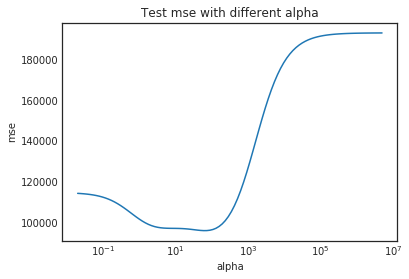

In [15]:
alphas = 5**np.linspace(10,-2,100)*0.5 


mse = []

for a in alphas:
    ridge2 = Ridge(alpha=a)
    ridge2.fit(scaler.transform(X_train), y_train)
    pred = ridge2.predict(scaler.transform(X_test))
    mse.append(mean_squared_error(y_test, pred))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Test mse with different alpha')

#### Compute the regularization path using RidgeCV
Ridge regression with built-in cross-validation.

Default cross validation method is "Generalized Cross-Validation" (efficient Leave-One-Out).

In [16]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([4.88281250e+06, 4.01741235e+06, 3.30539050e+06, 2.71956308e+06,
       2.23756418e+06, 1.84099184e+06, 1.51470558e+06, 1.24624833e+06,
       1.02537082e+06, 8.43640297e+05, 6.94118595e+05, 5.71097214e+05,
       4.69879399e+05, 3.86600818e+05, 3.18082028e+05, 2.61707094e+05,
       2.15323712e+05, 1.77161040e+05, 1.45762089e+05, 1.19928098e+05,
       9.86727677e+04, 8.11846033e+0...
       3.73150948e-01, 3.07015931e-01, 2.52602285e-01, 2.07832585e-01,
       1.70997595e-01, 1.40691016e-01, 1.15755791e-01, 9.52399351e-02,
       7.83601852e-02, 6.44721001e-02, 5.30454551e-02, 4.36439996e-02,
       3.59088012e-02, 2.95445425e-02, 2.43082465e-02, 2.00000000e-02]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [17]:
# Optimal alpha that RidgeCV found
ridgecv.alpha_

106.87349666729351

In [18]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
# Compare this mse value with an above graph (MSE with different alpha)

97171.90036529172

In [19]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           6.527403
Hits           22.754323
HmRun          19.213875
Runs           20.029787
RBI            21.072806
Walks          57.407651
Years          -5.790283
CAtBat         20.637323
CHits          29.977244
CHmRun         14.050638
CRuns          37.018236
CRBI           20.284659
CWalks         24.526594
PutOuts        16.522197
Assists       -45.652512
Errors         56.322520
League_N        6.000427
Division_W     -0.571164
NewLeague_N    11.210351
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

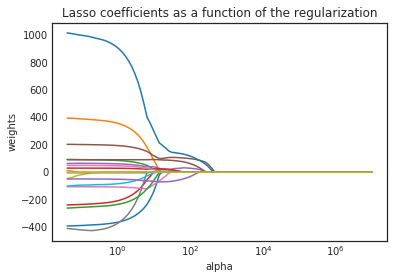

In [20]:
# Lasso in Scikit-learn has a max iteration since it uses "Coordinate descent solver"
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

#### Training mse with different alpha value

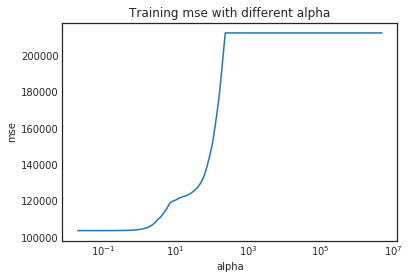

In [21]:
lasso = Lasso(max_iter=10000)
mse = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    
    mse.append(mean_squared_error(y_train, lasso.predict(scale(X_train))))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### Test mse with different alpha value

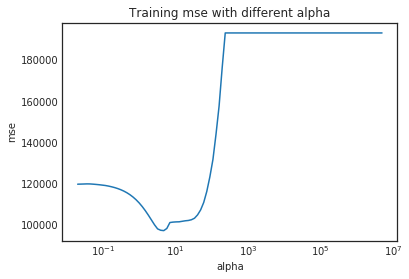

In [22]:
lasso = Lasso(max_iter=10000)
mse = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    
    mse.append(mean_squared_error(y_test, lasso.predict(scale(X_test))))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### Compute the regularization path using RidgeCV
Lasso regression with built-in cross-validation.

Alphas are set automatically

In [23]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.as_matrix().ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [24]:
lassocv.alpha_

30.01382256446427

In [25]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696965

In [26]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [27]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


0         1         2         3         4         5
0  0.198290 -0.383784  0.088626  0.031967  0.028117 -0.070646
1  0.195861 -0.377271  0.074032  0.017982 -0.004652 -0.082240
2  0.204369 -0.237136 -0.216186 -0.235831  0.077660 -0.149646
3  0.198337 -0.377721 -0.017166 -0.049942 -0.038536 -0.136660
4  0.235174 -0.314531 -0.073085 -0.138985  0.024299 -0.111675

The above loadings are the same as in R.

In [28]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


0         1         2         3         4         5
0 -0.009649  1.870522  1.265145 -0.935481  1.109636  1.211972
1  0.411434 -2.429422 -0.909193 -0.264212  1.232031  1.826617
2  3.466822  0.825947  0.555469 -1.616726 -0.857488 -1.028712
3 -2.558317 -0.230984  0.519642 -2.176251 -0.820301  1.491696
4  1.027702 -1.573537  1.331382  3.494004  0.983427  0.513675

The above principal components are the same as in R.

In [29]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

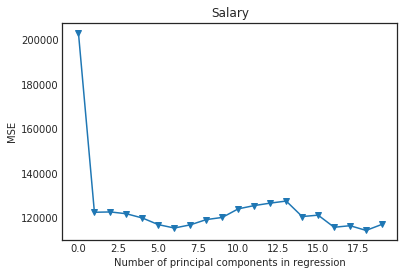

In [30]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [31]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

#### Fitting PCA with training data

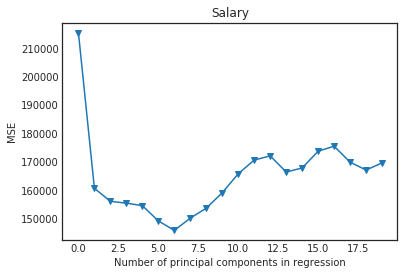

In [32]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components
# principal component graph - mse

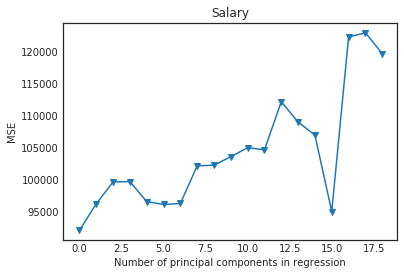

In [33]:
mse = []

for i in np.arange(1, 20):
    X_reduced_test = pca2.transform(scale(X_test))[:,:i]

    # Train regression model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], y_train)

    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    mse.append(mean_squared_error(y_test, pred)) 


plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

### 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

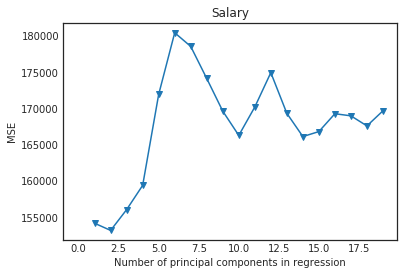

In [34]:
# Select best # of components using CV
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

### Test mse with different # of principal components in regression

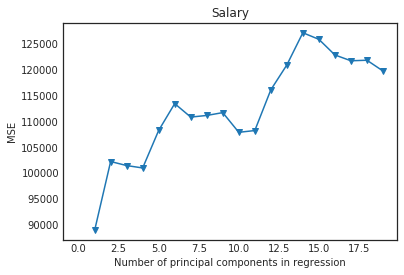

In [35]:

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    pls.fit(scale(X_train), y_train)

    mse.append(mean_squared_error(y_test, pls.predict(scale(X_test))))

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);